Below use [Currie, Iain G., and I. G. Currie. Fundamental mechanics of fluids. CRC press, 2002.] chapter 4.
Even though the derivation itself is valid, dF_dz has a sqrt term which is not a single-valued funciton, it's difficult to tell which branch of the sqrt term we should use when we try to get u and v. The numpy package will choose one branch in its own way without throwing any reminder/warning and does not meet our need. 

In [1]:
import sympy as sp

# Define symbols
z = sp.symbols('z', complex=True)
zeta = sp.symbols('zeta', complex=True)
# Define constants as symbols
U = sp.symbols('U', real=True)  # Free stream velocity
alpha = sp.symbols('alpha', real=True)  # Angle of attack
a = sp.symbols('a', real=True)  # cylinder radius
c = sp.symbols('c', real=True)  # conformal transformation parameter

# Define a complex function
F_z = U * (z * sp.exp(-sp.I * alpha) + (z / 2 - sp.sqrt((z / 2)**2 - c**2)) * (a**2 / c**2 * sp.exp(sp.I * alpha) - sp.exp(-sp.I * alpha)))

# Differentiate the complex function with respect to z
dF_dz = sp.diff(F_z, z)

# Separate into real and imaginary parts
u = sp.re(dF_dz)  # x-component of velocity
v = -sp.im(dF_dz)  # y-component of velocity

# Print results
print("Complex Derivative (dF/dz):", dF_dz)
print("Real Part (u):", u)
print("Imaginary Part (v):", v)


Complex Derivative (dF/dz): U*((-z/(4*sqrt(-c**2 + z**2/4)) + 1/2)*(a**2*exp(I*alpha)/c**2 - exp(-I*alpha)) + exp(-I*alpha))
Real Part (u): U*(a**2*cos(alpha)/(2*c**2) - a**2*re(z*exp(I*alpha)/sqrt(-c**2 + z**2/4))/(4*c**2) + cos(alpha)/2 + re(z*exp(-I*alpha)/sqrt(-c**2 + z**2/4))/4)
Imaginary Part (v): -U*(a**2*sin(alpha)/(2*c**2) - a**2*im(z*exp(I*alpha)/sqrt(-c**2 + z**2/4))/(4*c**2) - sin(alpha)/2 + im(z*exp(-I*alpha)/sqrt(-c**2 + z**2/4))/4)


In [2]:
# break down the complex function into two terms
term1_F_z = U * z * sp.exp(-sp.I * alpha)
term2_F_z = U * (z / 2 - sp.sqrt((z / 2)**2 - c**2)) * (a**2 / c**2 * sp.exp(sp.I * alpha) - sp.exp(-sp.I * alpha))

dF_dz_term1 = sp.diff(term1_F_z, z)
dF_dz_term2 = sp.diff(term2_F_z, z)
print(dF_dz_term1)
print(dF_dz_term2)

U*exp(-I*alpha)
U*(-z/(4*sqrt(-c**2 + z**2/4)) + 1/2)*(a**2*exp(I*alpha)/c**2 - exp(-I*alpha))


The following is an example np fails to handle the branch properly.

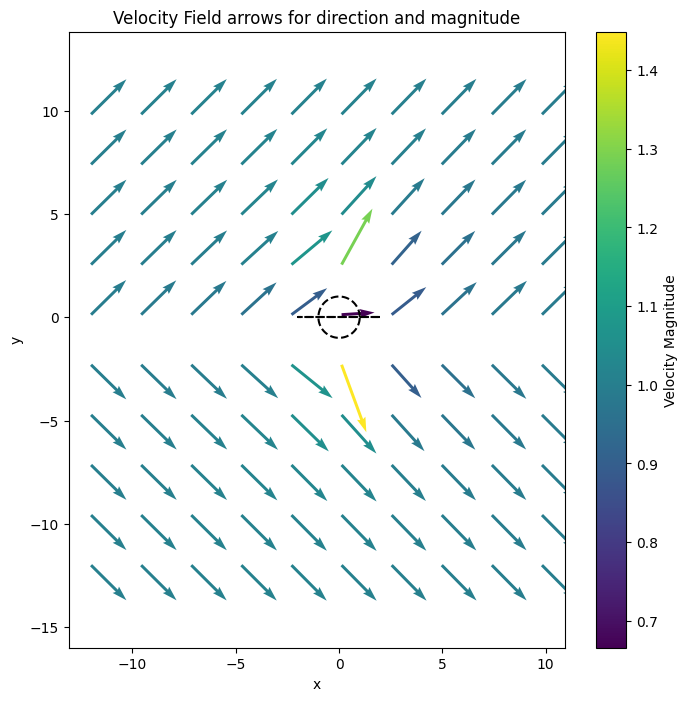

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
U = 1.0  # Freestream velocity
alpha = np.pi / 4  # Angle of attack in radians
# alpha = 0.0  # Angle of attack in radians
a = 1.0  # Semi-major axis
c = 1.0  # Semi-minor axis

# Define a grid of points in the field
field_dimension = 12
x = np.linspace(-field_dimension, field_dimension, 100)
y = np.linspace(-field_dimension, field_dimension, 100)
X, Y = np.meshgrid(x, y)
# Initialize arrays for velocity components
u = np.zeros_like(X)
v = np.zeros_like(Y)

# Compute the complex derivative dF/dz directly from the derived formula using a for loop
for i in range(len(x)):
    for j in range(len(y)):
        Z = x[i] + 1j * y[j]
        dF_dz_term1 = U * np.exp(-1j * alpha)
        dF_dz_term2 = U * (-Z / (4 * np.sqrt(-c**2 + Z**2 / 4)) + 1 / 2) * (a**2 * np.exp(1j * alpha) / c**2 - np.exp(-1j * alpha))
        dF_dz = dF_dz_term1 + dF_dz_term2
        u[i, j] = np.real(dF_dz)  # x-component of velocity
        v[i, j] = -np.imag(dF_dz)  # y-component of velocity

u[np.isnan(u)] = 0
v[np.isnan(v)] = 0

# Visualize the velocity field
plt.figure(figsize=(8, 8))
plt.title("Velocity Field arrows for direction and magnitude")
plt.quiver(X[::10, ::10], Y[::10, ::10], u[::10, ::10], v[::10, ::10], np.sqrt(u[::10, ::10]**2 + v[::10, ::10]**2), angles='xy', scale=10, cmap="viridis")
# plt.streamplot(X, Y, u, v, density=1.5, color=np.sqrt(u**2 + v**2))
# plt.title("Velocity Field Around an Ellipse (Using dF/dz)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.colorbar(label="Velocity Magnitude")

# plot cylinder of radius a
theta = np.linspace(0, 2 * np.pi, 100)
x_cylinder = a * np.cos(theta)
y_cylinder = a * np.sin(theta)
plt.plot(x_cylinder, y_cylinder, color="black", linestyle="--", label="Cylinder")
# plot ellipse
x_ellipse = (a + c**2/a) * np.cos(theta)
y_ellipse = (a - c**2/a) * np.sin(theta)
plt.plot(x_ellipse, y_ellipse, color="black", linestyle="--", label="Ellipse")


plt.show()


- Below follows [Acheson, David J. Elementary fluid dynamics. Oxford University Press, 1990] section 4.8
- Set c = a to compress the ellipse into a flat plate
- Evenly grid-sample z and then convert z to Z field using Z = z + c**2 / z 
- From Z = z + c**2 / z, there are 2 solutions of z for the same Z: when z dominate the expression or when 1/z dominate the expression. This basically means we can choose either the outside or inside of the |z| = c to map to the field of Z. We choose the outside. 
- As we want to let z -> Z as z -> infinity, we choose z outside (z dominate the expression).
- Also see [Currie, Iain G., and I. G. Currie. Fundamental mechanics of fluids. CRC press, 2002.] section 4.13.

In [4]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt

# Define constants
U = 1.0  # Freestream velocity
alpha = np.pi / 2  # Angle of attack in radians
a = 1.0  # cylinder radius

field_dimension = 4
# Traverse a range of x and y
x_range = np.linspace(-field_dimension, field_dimension, 50)
y_range = np.linspace(-field_dimension, field_dimension, 50)
u_field = np.zeros((len(x_range), len(y_range)))
v_field = np.zeros((len(x_range), len(y_range)))
X_field = np.zeros((len(x_range), len(y_range)))
Y_field = np.zeros((len(x_range), len(y_range)))

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        z = x + 1j * y
        if np.abs(z) > a + 0.01:
            Z = z + a**2 / z
            X_field[i, j] = np.real(Z)  # x of ellipse field
            Y_field[i, j] = np.imag(Z)  # y of ellipse field
            dWdz = (U * np.exp(-1j * alpha) - U * np.exp(1j * alpha) * a**2 / z**2) / (1 - a**2 / z**2)
            u_field[i, j] = np.real(dWdz)
            v_field[i, j] = -np.imag(dWdz)

# Visualize the velocity field
plt.figure(figsize=(8, 8))
plt.title("Velocity Field arrows for direction and magnitude")
plt.quiver(X_field, Y_field, u_field, v_field, angles='xy', scale=50, cmap="viridis")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.colorbar(label="Velocity Magnitude")

# plot a line from -2a to 2a
x_line = np.linspace(-2*a, 2*a, 100)
y_line = np.zeros_like(x_line)
plt.plot(x_line, y_line, color="black", linestyle="--", label="Line from -a to a")

plt.show()


it turns out that np.abs(0.5*Z + 0.5*np.sqrt(Z**2 - 4*c**2)) > c when Z has positive real part. 

In [5]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt

c = 2.0

field_dimension = 4
# Traverse a range of x and y
X_range = np.linspace(-field_dimension, field_dimension, 50)
Y_range = np.linspace(-field_dimension, field_dimension, 50)
branch_field = np.zeros((len(x_range), len(y_range)))

for i, X in enumerate(X_range):
    for j, Y in enumerate(Y_range):
        Z = X + 1j * Y
        if np.abs(0.5*Z + 0.5*np.sqrt(Z**2 - 4*c**2)) > c:
            branch_field[i, j] = 1
        else:
            branch_field[i, j] = -1

# Visualize branch field
plt.figure(figsize=(8, 8))
plt.title("Branch Field")
plt.contourf(X_range, Y_range, branch_field.T, cmap="viridis")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.colorbar(label="Branch Field")
plt.show()
            

Now we evenly grid-sample Z and then convert Z to z field, ensuring |z| > c

In [ ]:
%matplotlib tk
import numpy as np
import warnings
import matplotlib.pyplot as plt

# Define constants
U = 12.0  # Freestream velocity
alpha = np.pi / 2  # Angle of attack in radians
a = 1.0  # cylinder radius which maps to a flat plate of length = 4a
c = a   # conformal transformation from cylinder to flat plate

field_dimension = 2
# Traverse a range of x and y
X_range = np.linspace(-field_dimension, field_dimension, 10)
Y_range = np.linspace(-field_dimension, field_dimension, 10)
X_field = np.zeros((len(X_range), len(Y_range)))
Y_field = np.zeros((len(X_range), len(Y_range)))
u_field = np.zeros((len(X_range), len(Y_range)))
v_field = np.zeros((len(X_range), len(Y_range)))


for i, X in enumerate(X_range):
    for j, Y in enumerate(Y_range):
        Z = X + 1j * Y
        X_field[i, j] = X 
        Y_field[i, j] = Y 
        z1 = 0.5*Z + 0.5*np.sqrt(Z**2 - 4*c**2)
        z2 = 0.5*Z - 0.5*np.sqrt(Z**2 - 4*c**2)
        if np.abs(z1) > c:
            z = z1            
        elif np.abs(z2) > c:
            z = z2
        else:
            warnings.warn("Invalid z: expecting |z| > c")
        dWdz = (U * np.exp(-1j * alpha) - U * np.exp(1j * alpha) * a**2 / z**2) / (1 - a**2 / z**2)
        u_field[i, j] = np.real(dWdz)
        v_field[i, j] = -np.imag(dWdz)

# Visualize the velocity field
plt.figure(figsize=(8, 8))
plt.title("Velocity Field arrows for direction and magnitude")
plt.quiver(X_field, Y_field, u_field, v_field, np.sqrt(u_field**2 + v_field**2), angles='xy', scale=500, cmap="viridis")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.colorbar(label="Velocity Magnitude")

# plot a line from -2a to 2a
x_line = np.linspace(-2*a, 2*a, 100)
y_line = np.zeros_like(x_line)
plt.plot(x_line, y_line, color="black", linestyle="--", label="Line from -2a to 2a")

plt.show()

velocity_norm = np.sqrt(u_field**2 + v_field**2)
for row in velocity_norm.T:
    print(" ".join(f"{value:6.1f}" for value in row))

   8.0    7.0    6.3    5.7    5.4    5.4    5.7    6.3    7.0    8.0
   7.7    6.5    5.5    4.8    4.4    4.4    4.8    5.5    6.5    7.7
   7.3    5.9    4.7    3.8    3.3    3.3    3.8    4.7    5.9    7.3
   7.1    5.4    4.0    2.8    2.1    2.1    2.8    4.0    5.4    7.1
   6.9    5.1    3.5    2.1    0.9    0.9    2.1    3.5    5.1    6.9
   6.9    5.1    3.5    2.1    0.9    0.9    2.1    3.5    5.1    6.9
   7.1    5.4    4.0    2.8    2.1    2.1    2.8    4.0    5.4    7.1
   7.3    5.9    4.7    3.8    3.3    3.3    3.8    4.7    5.9    7.3
   7.7    6.5    5.5    4.8    4.4    4.4    4.8    5.5    6.5    7.7
   8.0    7.0    6.3    5.7    5.4    5.4    5.7    6.3    7.0    8.0
